In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reading in data from the pair potential table file

In [3]:
pdb = PDBFile('water512_CG.pdb')
table_file = '1_1_bumper_10.table'

coordinates_in_angstroms = pdb.positions
coordinates_in_nanometers = coordinates_in_angstroms / 10.0

energies = []  # energy values
distances = []  # distance values

with open(table_file, 'r') as file:
    for _ in range(5):
        next(file)

    for line in file:
        columns = line.split()

        distance = float(columns[1])
        energy = float(columns[2])
        distance = distance*0.1   # converts to nm
        energy = energy*4.184     # converts to kJ/mol

        distances.append(distance)
        energies.append(energy)

In [4]:
# Create an OpenMM System
system = openmm.System()

box_size = 2.5022 * nanometers
system.setDefaultPeriodicBoxVectors([box_size, 0, 0], [0, box_size, 0], [0, 0, box_size])

In [5]:
# Define the non-bonded forces (tabulated function)

tabulated_function = openmm.Continuous1DFunction(energies, 0.0005, 1.0, False)

nonbond_force_charges = openmm.NonbondedForce()
nonbond_force = openmm.CustomNonbondedForce('energy(r)')
nonbond_force.addTabulatedFunction('energy', tabulated_function)
nonbond_force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
nonbond_force.setCutoffDistance(1.0)
nonbond_force_charges.setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)
nonbond_force_charges.setCutoffDistance(1.0)

charge = 0.0
sigma = 0.0
epsilon = 0.0
for atom in pdb.topology.atoms():
    nonbond_force.addParticle()
    nonbond_force_charges.addParticle(charge, sigma, epsilon)

for atom in pdb.topology.atoms():
    mass = 18.015400 * amu
    system.addParticle(mass)

total_mass = system.getNumParticles() * mass

for particle_index in range(system.getNumParticles()):
    charge = nonbond_force_charges.getParticleParameters(particle_index)[0]
    mass = system.getParticleMass(particle_index).value_in_unit(amu)

# Add the CustomNonbondedForce to the System
system.addForce(nonbond_force)
system.addForce(nonbond_force_charges)

1

In [6]:
# Molecular Dynamics

integrator = NoseHooverIntegrator(300*kelvin, 0.1, 0.002*picoseconds, 4, 1, 1)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(coordinates_in_nanometers)

simulation.context.setPeriodicBoxVectors([box_size, 0, 0], [0, box_size, 0], [0, 0, box_size])
simulation.minimizeEnergy()

# Number of steps for heating
heating_steps = 1000

# Increment the temperature linearly over heating_steps
for step in range(heating_steps):
    current_temp = 300 * (step / heating_steps) * kelvin
    simulation.context.setVelocitiesToTemperature(current_temp)
    simulation.step(1)

simulation.context.setVelocitiesToTemperature(300*kelvin)
simulation.reporters.append(DCDReporter('output.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True))
#simulation.reporters.append(ForceReporter('forces.txt', 1000))

# Get the state
state = simulation.context.getState(getPositions=True, getVelocities=True, getEnergy=True, getForces=True, getParameters=True, enforcePeriodicBox=True)

# Extract the box vectors
print("Box Vectors:", state.getPeriodicBoxVectors())

# Retrieve and print the starting coordinates
state = simulation.context.getState(getPositions=True)
positions = state.getPositions()

# Optionally, you can save the starting coordinates to a file for further inspection
with open("starting_coordinates.txt", "w") as f:
    for i, pos in enumerate(positions):
        f.write(f"Particle {i}: {pos}\n")

print(f"Temperature: {integrator.getTemperature()}")
print(f"Timestep: {integrator.getStepSize()}")
print(f"Collision frequency: {integrator.getCollisionFrequency()}")

Box Vectors: [Vec3(x=2.5022, y=0.0, z=0.0), Vec3(x=0.0, y=2.5022, z=0.0), Vec3(x=0.0, y=0.0, z=2.5022)] nm
Temperature: 300.0 K
Timestep: 0.002 ps
Collision frequency: 0.1 /ps


In [7]:
simulation.step(100000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
2000,-677.9759478569031,185.1121193662247
3000,-685.8830788135529,199.01980752955347
4000,-586.0321590304375,195.02326582437072
5000,-645.5170748233795,214.88750538218517
6000,-591.2978405952454,216.57139330159788
7000,-545.7651176452637,219.79740545520758
8000,-516.5791461467743,225.96832066445376
9000,-527.8161929249763,239.37586638524138
10000,-454.7179934978485,236.68875131924096
11000,-469.8285979628563,251.2912982829717
12000,-389.5461076647043,250.4288938362279
13000,-334.1834199130535,254.25091772592907
14000,-414.25432741642,276.48980542275257
15000,-374.6431999206543,279.8433132861222
16000,-268.4263305068016,270.81812378886997
17000,-270.34899973869324,283.7894208694944
18000,-268.1840845942497,290.6329260440121
19000,-352.2367271184921,313.70307181777866
20000,-176.3555542230606,293.3786922417667
21000,-180.74582707881927,301.34561723807457
22000,-302.90706568956375,329.314116045714
23000,-183.97465336322784,311.3945165

In [8]:
# Print system characteristics
def print_system_info(system):
    print("Number of particles:", system.getNumParticles())
    print("Number of constraints:", system.getNumConstraints())
    print("Number of forces:", system.getNumForces())

    for i in range(system.getNumForces()):
        force = system.getForce(i)
        print(f"\nForce {i}: {type(force).__name__}")
        
        if isinstance(force, CustomNonbondedForce):
            print("  Energy function:", force.getEnergyFunction())
            print("  Number of particles:", force.getNumParticles())
            print("  Number of exclusions:", force.getNumExclusions())
            print("  Nonbonded method:", force.getNonbondedMethod())
            print("  Cutoff distance (nm):", force.getCutoffDistance().value_in_unit(nanometers))
            for j in range(force.getNumTabulatedFunctions()):
                func = force.getTabulatedFunction(j)
                print(f"  Tabulated function {j}: {type(func).__name__}")

        if isinstance(force, NonbondedForce):
            print("  Number of particles:", force.getNumParticles())
            print("  Nonbonded method:", force.getNonbondedMethod())
            print("  Cutoff distance (nm):", force.getCutoffDistance().value_in_unit(nanometers))

# Call the function to print the system info
print_system_info(system)

Number of particles: 512
Number of constraints: 0
Number of forces: 2

Force 0: CustomNonbondedForce
  Energy function: energy(r)
  Number of particles: 512
  Number of exclusions: 0
  Nonbonded method: 2
  Cutoff distance (nm): 1.0
  Tabulated function 0: Continuous1DFunction

Force 1: NonbondedForce
  Number of particles: 512
  Nonbonded method: 2
  Cutoff distance (nm): 1.0


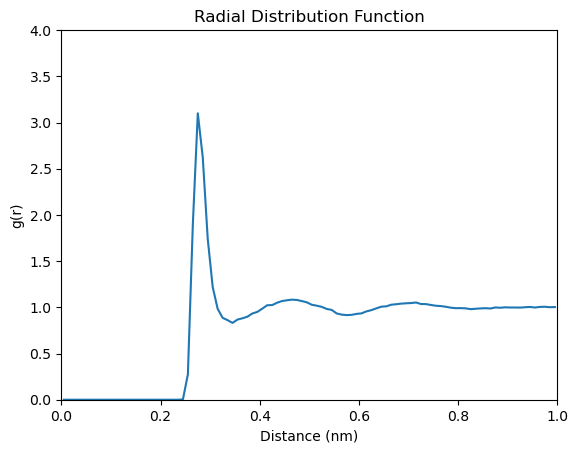

In [9]:
# Load the trajectory
traj = md.load('output.dcd', top='water512_CG.pdb')
traj = traj[-200:]

# Define atom pairs for which to compute the RDF (all the CG beads here)
oxygen_atoms = traj.topology.select('name O')

# Compute RDF
rdf, r = md.compute_rdf(traj, pairs=traj.topology.select_pairs(oxygen_atoms, oxygen_atoms), r_range=(0.0, 1.0), bin_width=0.01)

# Plot RDF
plt.plot(rdf, r)
plt.ylim(0.0, 4.0)
plt.xlim(0.0, 1.0)
plt.xlabel('Distance (nm)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()